<a href="https://colab.research.google.com/github/wjdolan/DS_Portfolio/blob/main/CNN_time_series_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Using CNN's for time series prediction

Evaluate using CNN's for time series prediction


*   compare against LSTM
*   use stock price time series



In [8]:
#!pip install yfinance

In [9]:
import yfinance
import numpy as np

In [10]:
df = yfinance.download('XOM', '2002-8-1','2022-11-1')
df = df.drop(['Volume'],1).drop(['Adj Close'],1)

[*********************100%***********************]  1 of 1 completed


<ipython-input-10-d6575a998335>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  df = df.drop(['Volume'],1).drop(['Adj Close'],1)


In [11]:
# create function to normalize the dataset

def normalize_data(dataset):
        cols = dataset.columns.tolist()
        col_name = [0]*len(cols)
        for i in range(len(cols)):
            col_name[i] = i
        dataset.columns = col_name
        dtypes = dataset.dtypes.tolist()
        minmax = list()
        for column in dataset:
            dataset = dataset.astype({column: 'float32'})
        for i in range(len(cols)):
            col_values = dataset[col_name[i]]
            value_min = min(col_values)
            value_max = max(col_values)
            minmax.append([value_min, value_max])
        for column in dataset:
            values = dataset[column].values
            for i in range(len(values)):
                values[i] = (values[i] - minmax[column][0]) / (minmax[column][1] - minmax[column][0])
            dataset[column] = values
        dataset[column] = values
        return dataset,minmax
    
dataset,minmax = normalize_data(df)
print(df.values)
values = dataset.values

[[ 35.25        35.79000092  33.50999832  33.65000153]
 [ 33.84999847  34.25        32.79999924  33.61000061]
 [ 33.65000153  34.24000168  32.31999969  32.5       ]
 ...
 [108.41000366 109.58000183 107.41999817 107.55000305]
 [109.45999908 111.20999908 108.12000275 110.69999695]
 [109.5        112.91000366 109.44000244 110.80999756]]


In [12]:
# convert sequences into dataset (y=closing price, x=everything else)

def split_sequences(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def data_setup(n_steps, n_seq,sequence):
    X, y = split_sequences(sequence, n_steps)
    n_features = X.shape[2]
    X = X.reshape((len(X),n_steps, n_features))
    new_y = []
    for term in y:
        new_term = term[-1]
        new_y.append(new_term)
    return X, np.array(new_y), n_features
    
n_steps = 10
n_seq = 10000
rel_test_len = 0.1
X,y,n_features = data_setup(n_steps,n_seq,values)
X = X[:-1]
y = y[1:]
X_test,y_test = X[:int(len(X)*rel_test_len)],y[:int(len(X)*rel_test_len)]
X_train,y_train = X[int(len(X)*rel_test_len):],y[int(len(X)*rel_test_len):]
X.shape

(5088, 10, 4)

In [14]:
# create LSTM model

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(64, activation=None, input_shape=(10,4), return_sequences = True))
model.add(LSTM(32, activation=None, return_sequences = True))
model.add(Flatten())
model.add(Dense(100, activation=None))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mse', optimizer='adam')

In [15]:
# create CNN model

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

model = Sequential()
model.add(Conv1D(filters=128, kernel_size=3, activation='relu', input_shape=(10,4)))
model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='mse', optimizer='adam')


In [18]:
# train the models

import os
from keras import callbacks

epochs = 1000
verbosity = 1
dirx = '/content/drive/MyDrive/CNN_stock'
os.chdir(dirx)
h5 = 'network.h5'
checkpoint = callbacks.ModelCheckpoint(h5,
                                       monitor='val_loss',
                                       verbose=0,
                                       save_best_only=True,
                                       save_weights_only=True,
                                       mode='auto',
                                       save_freq='epoch')
callback = [checkpoint]
json = 'network.json'
model_json = model.to_json()

with open(json, "w") as json_file:
    json_file.write(model_json)

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=len(X_train) // 4,
                    validation_data = (X_test,y_test),
                    verbose=verbosity,
                    callbacks=callback)

Epoch 1/1000
4/4 [==============================] - 0s 124ms/step - loss: 4.9077e-04 - val_loss: 9.0636e-05
Epoch 2/1000
4/4 [==============================] - 0s 66ms/step - loss: 4.9646e-04 - val_loss: 8.9450e-05
Epoch 3/1000
4/4 [==============================] - 0s 63ms/step - loss: 4.6061e-04 - val_loss: 8.9716e-05
Epoch 4/1000
4/4 [==============================] - 0s 70ms/step - loss: 4.8369e-04 - val_loss: 9.3509e-05
Epoch 5/1000
4/4 [==============================] - 0s 74ms/step - loss: 4.8381e-04 - val_loss: 8.4949e-05
Epoch 6/1000
4/4 [==============================] - 0s 64ms/step - loss: 4.9850e-04 - val_loss: 9.2224e-05
Epoch 7/1000
4/4 [==============================] - 0s 110ms/step - loss: 4.6923e-04 - val_loss: 9.6482e-05
Epoch 8/1000
4/4 [==============================] - 0s 112ms/step - loss: 4.7508e-04 - val_loss: 8.5226e-05
Epoch 9/1000
4/4 [==============================] - 0s 109ms/step - loss: 4.9343e-04 - val_loss: 9.4908e-05
Epoch 10/1000
4/4 [==============

In [21]:
# import loaded weights

from keras.models import load_model, model_from_json
def load_keras_model(optimizer):
    dirx = '/content/drive/MyDrive/CNN_stock'
    os.chdir(dirx)
    json_file = open('network.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    model = model_from_json(loaded_model_json)
    model.compile(optimizer=optimizer, loss='mse')
    model.load_weights('network.h5')
    return model
model = load_keras_model('adam')

In [22]:
model.evaluate(X_test,y_test)

16/16 [==============================] - 0s 3ms/step - loss: 8.3920e-05


8.39203639770858e-05

16/16 [==============================] - 0s 2ms/step


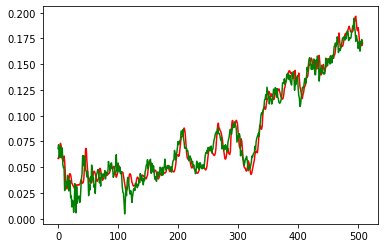

In [23]:
from matplotlib import pyplot as plt

pred_test = model.predict(X_test)
plt.plot(pred_test,'r')
plt.plot(y_test,'g')
